In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('dataset/df_train_slim.csv')
# df.head()
df.shape

(50704, 58)

In [3]:
dtypes = {col:'category' for col in df.select_dtypes('object').columns.tolist()}
df = df.astype(dtype=dtypes)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50704 entries, 0 to 50703
Data columns (total 58 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Make                            50704 non-null  category
 1   Model                           50704 non-null  category
 2   YearGroup                       50704 non-null  int64   
 3   LimitedEdition                  50704 non-null  bool    
 4   BadgeDescription                44099 non-null  category
 5   BodyStyleDescription            50704 non-null  category
 6   DriveCode                       50704 non-null  category
 7   GearTypeDescription             50704 non-null  category
 8   GearLocationDescription         50704 non-null  category
 9   GearNum                         50703 non-null  float64 
 10  DoorNum                         50704 non-null  int64   
 11  EngineSize                      50704 non-null  int64   
 12  Cylinders         

In [4]:
## remove nan for Sold_Amount
df = df[df['Sold_Amount'].notna()]

In [5]:
def prepare_data(select_columns=df.columns.tolist()):
    
    target_column='Sold_Amount'
    DF = df[select_columns].copy()
    
    if target_column in DF.columns:
        x = DF.drop(columns=target_column)
    else:
        x = DF
        
    y = df['Sold_Amount']
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [6]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = prepare_data(select_columns=df.columns.tolist())

# X_train, y_train
X_train.shape, X_test.shape

((40560, 57), (10140, 57))

### Define Tree model

In [7]:
def evaluate_model(model, X_test, y_test=y_test):
    # Test on y_test
    y_pred = model.predict(X_test)

    #  Measure model performance
    return {
        "r2score": r2_score(y_true=y_test, y_pred=y_pred), 
        "mse":mean_squared_error(y_true=y_test, y_pred=y_pred), 
        "mae":mean_absolute_error(y_true=y_test, y_pred=y_pred), 
        "rmse":root_mean_squared_error(y_true=y_test, y_pred=y_pred)
        }

In [8]:
def init_xgb(n_estimators=100, max_depth=10, device='cpu'):
    # Initialize the XGBoost Regressor
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=n_estimators,
        learning_rate=0.0001,
        max_depth=max_depth,
        random_state=42,
        enable_categorical=True,
        missing=np.nan,
        device=device
    )

    return model 

In [9]:
xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        enable_categorical=True,
        missing=np.nan,
    )
# Train the model
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-rmse:7687.58462
[1]	validation_0-rmse:6333.68337
[2]	validation_0-rmse:5385.56225
[3]	validation_0-rmse:4829.84723
[4]	validation_0-rmse:4447.77970
[5]	validation_0-rmse:4222.19242
[6]	validation_0-rmse:4015.12181
[7]	validation_0-rmse:3855.83435
[8]	validation_0-rmse:3768.10755
[9]	validation_0-rmse:3712.26857
[10]	validation_0-rmse:3667.83333
[11]	validation_0-rmse:3629.91442
[12]	validation_0-rmse:3613.29846
[13]	validation_0-rmse:3576.74945
[14]	validation_0-rmse:3545.71351
[15]	validation_0-rmse:3532.75601
[16]	validation_0-rmse:3517.28776
[17]	validation_0-rmse:3488.07921
[18]	validation_0-rmse:3475.41745
[19]	validation_0-rmse:3469.76425
[20]	validation_0-rmse:3468.66722
[21]	validation_0-rmse:3461.51219
[22]	validation_0-rmse:3448.13446
[23]	validation_0-rmse:3443.90388
[24]	validation_0-rmse:3437.50463
[25]	validation_0-rmse:3429.21294
[26]	validation_0-rmse:3425.20715
[27]	validation_0-rmse:3422.63755
[28]	validation_0-rmse:3420.42370
[29]	validation_0-rmse:3

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [10]:
evaluate_model(xgb_model, X_test, y_test=y_test)

{'r2score': 0.8795200413810288,
 'mse': np.float64(11244325.370961327),
 'mae': np.float64(1876.2267805820236),
 'rmse': np.float64(3353.2559357975238)}

### Feature Selection and importance

In [11]:
from xgboost import plot_importance, plot_tree

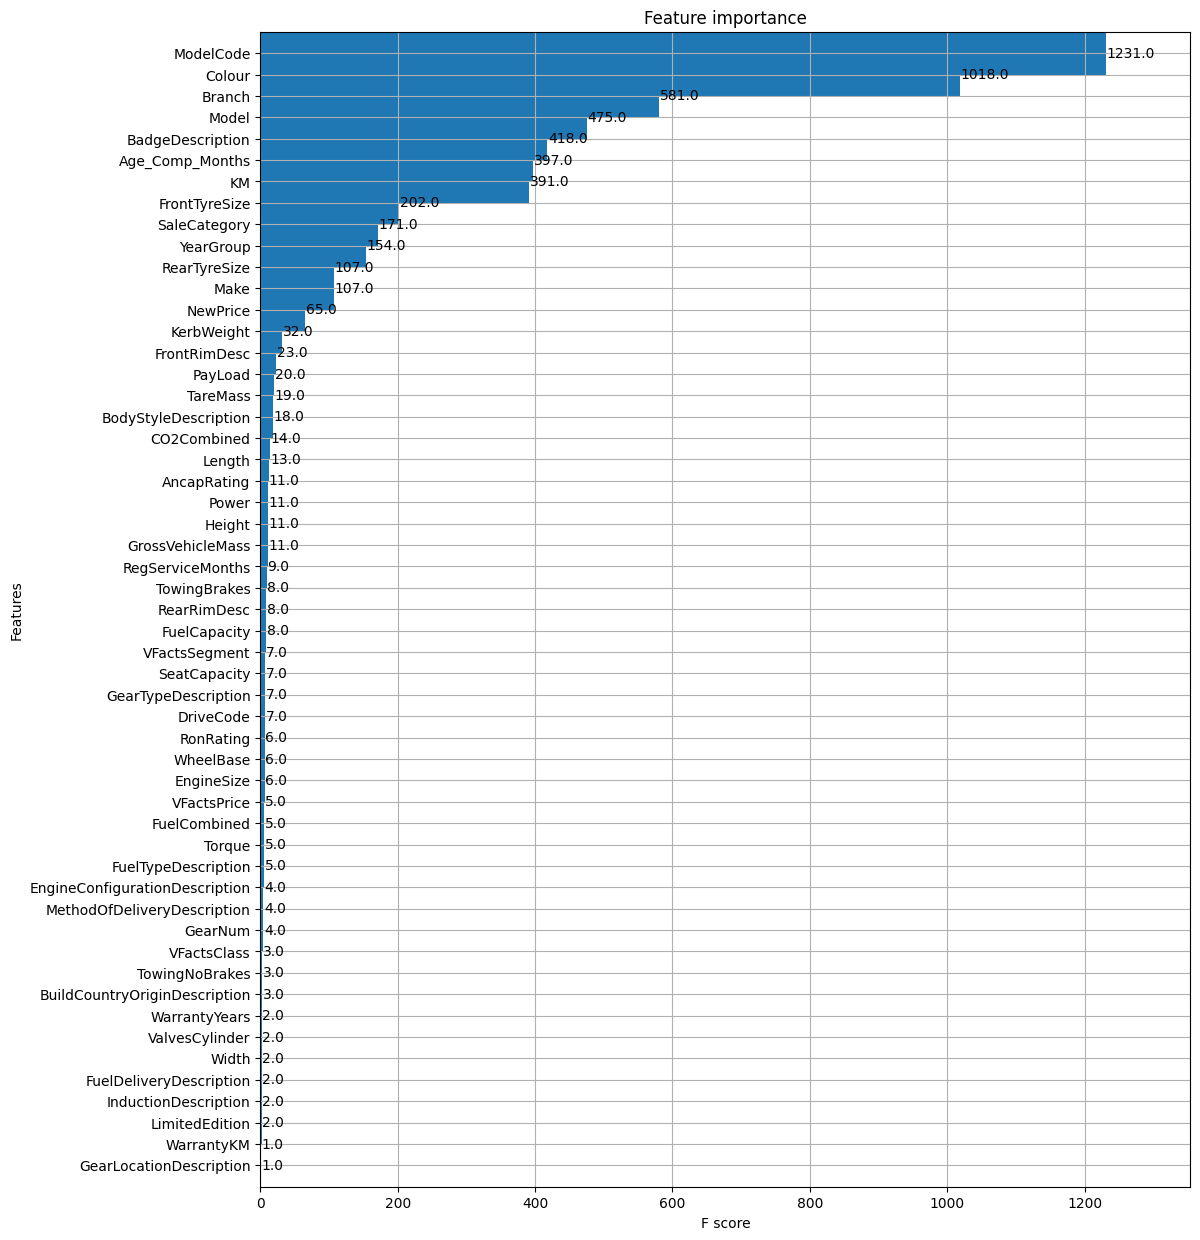

In [12]:
# plot feature importance
plt.rcParams["figure.figsize"] = (12, 15)
plot_importance(xgb_model, height=2);

### Select top 20 feature

In [13]:
df_feature = pd.DataFrame.from_dict(xgb_model.get_booster().get_score(), orient='index').reset_index()
df_feature.columns = ['feature', 'fscore']
df_feature.sort_values(by='fscore', ascending=False, inplace=True)

df_feature = df_feature.reset_index(drop=True)

top_features = df_feature['feature'][:20].tolist()
top_features

['ModelCode',
 'Colour',
 'Branch',
 'Model',
 'BadgeDescription',
 'Age_Comp_Months',
 'KM',
 'FrontTyreSize',
 'SaleCategory',
 'YearGroup',
 'RearTyreSize',
 'Make',
 'NewPrice',
 'KerbWeight',
 'FrontRimDesc',
 'PayLoad',
 'TareMass',
 'BodyStyleDescription',
 'CO2Combined',
 'Length']

In [14]:
# Split data into train and test sets
X_train2, X_test2, y_train2, y_test2 = prepare_data(select_columns=top_features)

# X_train, y_train
X_train2.shape, X_test2.shape

((40560, 20), (10140, 20))

In [15]:
xgb_model2 = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        enable_categorical=True,
        missing=np.nan,
    )
# Train the model
xgb_model2.fit(X_train2, y_train2, eval_set=[(X_test2, y_test2)])

[0]	validation_0-rmse:7696.86734
[1]	validation_0-rmse:6335.07726
[2]	validation_0-rmse:5379.22859
[3]	validation_0-rmse:4824.21291
[4]	validation_0-rmse:4454.72035
[5]	validation_0-rmse:4199.69094
[6]	validation_0-rmse:4021.49255
[7]	validation_0-rmse:3883.10074
[8]	validation_0-rmse:3784.76444
[9]	validation_0-rmse:3732.84926
[10]	validation_0-rmse:3685.12231
[11]	validation_0-rmse:3643.38106
[12]	validation_0-rmse:3618.86036
[13]	validation_0-rmse:3600.26399
[14]	validation_0-rmse:3578.43666
[15]	validation_0-rmse:3567.29474
[16]	validation_0-rmse:3552.95491
[17]	validation_0-rmse:3513.73905
[18]	validation_0-rmse:3503.48523
[19]	validation_0-rmse:3498.20635
[20]	validation_0-rmse:3494.15978
[21]	validation_0-rmse:3486.26973
[22]	validation_0-rmse:3483.91148
[23]	validation_0-rmse:3477.51713
[24]	validation_0-rmse:3473.42895
[25]	validation_0-rmse:3468.72959
[26]	validation_0-rmse:3465.11351
[27]	validation_0-rmse:3458.03288
[28]	validation_0-rmse:3452.17954
[29]	validation_0-rmse:3

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [16]:
# Model 1
evaluate_model(xgb_model, X_test, y_test=y_test)

{'r2score': 0.8795200413810288,
 'mse': np.float64(11244325.370961327),
 'mae': np.float64(1876.2267805820236),
 'rmse': np.float64(3353.2559357975238)}

In [17]:
# Model 2: Train only top N features, model is comparable to using 50 over features

evaluate_model(xgb_model2, X_test2, y_test=y_test2)

{'r2score': 0.8762154352700362,
 'mse': np.float64(11552742.36214227),
 'mae': np.float64(1902.0347908497497),
 'rmse': np.float64(3398.9325327435185)}

## Lightboost

In [18]:
from lightgbm import LGBMRegressor

In [19]:
# Create an instance of the LightGBM Regressor with the RMSE metric.
lgbm_model = LGBMRegressor(
                metric='rmse'
            )

# Train the model using the training data.
lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7348
[LightGBM] [Info] Number of data points in the train set: 40560, number of used features: 56
[LightGBM] [Info] Start training from score 16423.053517


LGBMRegressor(metric='rmse')

In [20]:
evaluate_model(lgbm_model, X_test, y_test=y_test)

{'r2score': 0.9140327637978878,
 'mse': np.float64(8023272.801378803),
 'mae': np.float64(1716.4365351189842),
 'rmse': np.float64(2832.5382259342596)}

### Infer on test set

In [21]:
with open("dataset/DatiumTest.rpt", "r", encoding="utf-8-sig") as fr: 
    test = fr.readlines()

# Prepare columns and data to a dataframe
columns = [col.replace("\n", "") for col in test[0].split("\t")]
data = [line.split("\t") for line in test[1:]]

dft = pd.DataFrame(data, columns=columns)

# More Clean up and conversion to float
dft.loc[:,'Sold_Amount'] = dft['Sold_Amount'].str.strip("\n").replace('NULL', np.nan).astype(float)

# exluding columns
exclude_cols = ['AvgWholesale', 'AvgRetail', 'GoodWholesale', 'GoodRetail', 'TradeMin', 'TradeMax', 'PrivateMax']
df_test = dft[dft.columns[~dft.columns.isin(exclude_cols)]].copy()

In [22]:
# Select columns
df_test = df_test[df.columns.tolist()]

# Preprocess data
df_test.loc[:, 'Sold_Amount'] = df_test['Sold_Amount'].astype(float)
df_test.replace('NULL', np.nan, inplace=True)

# convert to proper type
df_test = df_test.astype(df.dtypes.to_dict())

C:\Users\mokdx\AppData\Local\Temp\ipykernel_6032\3608813046.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test.replace('NULL', np.nan, inplace=True)


In [23]:
xx_test = df_test.drop(columns='Sold_Amount')
yy_test = df_test['Sold_Amount']

In [24]:
## Infer with xgboost model
evaluate_model(xgb_model, xx_test, yy_test)

{'r2score': 0.8535735865284761,
 'mse': np.float64(19001764.570669863),
 'mae': np.float64(2436.691302162452),
 'rmse': np.float64(4359.101348978923)}

In [33]:
## XGboost model with Top features
xx_test2 = df_test[top_features]

## Infer with xgboost model
evaluate_model(xgb_model2, xx_test2, yy_test)

{'r2score': 0.8478544214619957,
 'mse': np.float64(19743940.968749814),
 'mae': np.float64(2489.6052928382705),
 'rmse': np.float64(4443.415462091049)}

In [25]:
## Infer with lightgbm model
evaluate_model(lgbm_model, xx_test, yy_test)

{'r2score': 0.9067403251378797,
 'mse': np.float64(12102313.671787467),
 'mae': np.float64(2067.8763803445154),
 'rmse': np.float64(3478.837977225652)}